In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
import plotly.express as px
import datetime as dt
import warnings
warnings.filterwarnings('ignore')
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa import arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf,adfuller, kpss,range_unit_root_test # BDS for inped
from statsmodels.tsa.stattools import q_stat #Compute Ljung-Box Q Statistic.
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error
import scipy


#### We have decided using the dataset about global temperature are mainly focusing on two parts.
#### 1. Understanding climate change: One of the primary reasons for studying global temperature is to better understand climate change. By analyzing long-term trends in global temperature, so that we can track changes in the Earth's climate and assess the impacts of human activity on the environment.
#### 2. Predicting future climate patterns: Global temperature data can also be used to create models for predicting future climate patterns. These models can help us to forcast future temperature.

## For ARMIA
Member in charge：  
*   Hongliang Chen
*   Mingxin Xue

### 1. General Temperature Trend Analysis (Do our temperature data show trend?)
In this section, several attributes are selected and are visualied to see the temperature trend over these attributes.  

> 1) Average Temperature trend over year in general

> 2) Average Temperature trend over year by country

> 3) Average Temperature trend over year by latitude zone

> 4) Average Temperature trend in different season in 4 most popolated cities

> 5) Land Average Temperature, Land Max Temperature, Land Min Temperature, Land & Ocean Average Temperature change trend over year

In [2]:
# load the coresponding dataset fot hte section 
MajorCity_Temp = pd.read_csv('./processedData/processed_data.csv')

In [3]:
# check the AvgTemp distribution in MajorCity
MajorCity_Temp.head(1)
# convert datetime column data type 
MajorCity_Temp['datetime'] = pd.to_datetime(MajorCity_Temp['datetime'],format='%Y-%m-%d')
# extract year and monthe from datetime column for visualization convinence
MajorCity_Temp['year'] = MajorCity_Temp['datetime'].dt.strftime('%Y')
MajorCity_Temp['month'] = MajorCity_Temp['datetime'].dt.strftime('%m')

#### We can see that climate is arising over the years.

In [4]:
# visualization 1: Average Temperature trend over year in general
temp_avg_df = MajorCity_Temp.groupby(['year'])['AverageTemperature'].mean().reset_index()
temp_avg_trend = px.line(temp_avg_df, x='year', y='AverageTemperature')
temp_avg_trend.show()

#### The below graph shows the temperature for some countries

In [5]:
# visualization 2: Average Temperature trend over year by country
temp_avg_by_country_df = MajorCity_Temp.groupby(['year', 'Country'])['AverageTemperature'].mean().reset_index()
temp_avg_by_country_trend = px.line(temp_avg_by_country_df, x='year', y='AverageTemperature', color='Country')
temp_avg_by_country_trend.show()

#### Below graph shows the temperature for different latitude zone.

In [6]:
# visualization 3: Average Temperature trend over year by latitude zone
def latitude_classify(x):
  if -30 <= x <= 30: return 'low'
  elif -60 <= x < -30 or 30 < x <= 60: return 'middle'
  else: return 'high'

temp_avg_by_latitude_df = MajorCity_Temp[['year', 'month', 'AverageTemperature', 'Latitude']]
temp_avg_by_latitude_df['LatitudeZone'] = temp_avg_by_latitude_df['Latitude'].apply(lambda x: latitude_classify(x))
temp_avg_by_latitude_df2 = temp_avg_by_latitude_df.groupby(['year', 'LatitudeZone'])['AverageTemperature'].mean().reset_index()
temp_avg_by_latitude_trend = px.line(temp_avg_by_latitude_df2, x='year', y='AverageTemperature', color='LatitudeZone')
temp_avg_by_latitude_trend.show()

#### The graph below shows how temperature be different in different seasons

In [7]:
# visualization 4: 
# Most populated City 2023: Tokyo (37,435,191) Delhi (29,399,141) Shanghai (26,317,104) Peking (20,035,455)
# reference to https://worldpopulationreview.com/world-cities
tokyo_df = MajorCity_Temp[MajorCity_Temp['City'] == 'Tokyo']
delhi_df = MajorCity_Temp[MajorCity_Temp['City'] == 'Delhi']
shanghai_df = MajorCity_Temp[MajorCity_Temp['City'] == 'Shanghai']
peking_df = MajorCity_Temp[MajorCity_Temp['City'] == 'Peking']

def month_to_season(x):
  if x in ['03', '04', '05']: return 'spring'
  elif x in ['06', '07', '08']: return 'summer'
  elif x in ['09', '10', '11']: return 'fall'
  else: return 'winter'

tokyo_df = tokyo_df.groupby(['year', 'month']).agg({'AverageTemperature': 'mean'}).reset_index()
tokyo_df['season'] = tokyo_df['month'].apply(lambda x: month_to_season(x))
tokyo_trend = px.scatter(tokyo_df, x='year', y=['AverageTemperature'], color='season', trendline='ols', height=450, width=600, size_max=10, opacity=0.3)
tokyo_trend.show()

delhi_df = delhi_df.groupby(['year', 'month']).agg({'AverageTemperature': 'mean'}).reset_index()
delhi_df['season'] = delhi_df['month'].apply(lambda x: month_to_season(x))
delhi_trend = px.scatter(delhi_df, x='year', y=['AverageTemperature'], color='season', trendline='ols', height=450, width=600, size_max=10, opacity=0.3)
delhi_trend.show()

shanghai_df = shanghai_df.groupby(['year', 'month']).agg({'AverageTemperature': 'mean'}).reset_index()
shanghai_df['season'] = shanghai_df['month'].apply(lambda x: month_to_season(x))
shanghai_trend = px.scatter(shanghai_df, x='year', y=['AverageTemperature'], color='season', trendline='ols', height=450, width=600, size_max=10, opacity=0.3)
shanghai_trend.show()

peking_df = peking_df.groupby(['year', 'month']).agg({'AverageTemperature': 'mean'}).reset_index()
peking_df['season'] = peking_df['month'].apply(lambda x: month_to_season(x))
peking_trend = px.scatter(peking_df, x='year', y=['AverageTemperature'], color='season', trendline='ols', height=450, width=600, size_max=10, opacity=0.3)
peking_trend.show()

#### The below graph shows the land temperatures

In [8]:
# Visualization 5: Globally Land Average Temperature, Land Max Temperature, Land Min Temperature, Land & Ocean Average Temperature change trend over year
all_temp_df = MajorCity_Temp.groupby('year').agg({'LandAverageTemperature': 'mean', 'LandMaxTemperature': 'mean', 'LandMinTemperature': 'mean', 'LandAndOceanAverageTemperature': 'mean'}).reset_index()
all_temp_trend = px.line(all_temp_df, x='year', y=['LandAverageTemperature', 'LandMaxTemperature', 'LandMinTemperature', 'LandAndOceanAverageTemperature'])
all_temp_trend.show()

### 2. Seasonality Analysis (Do our data show seasonality?)

#### The graph below shows the global temperature for a year, we can see there is seasonality.

Text(0, 0.5, 'Temperature')

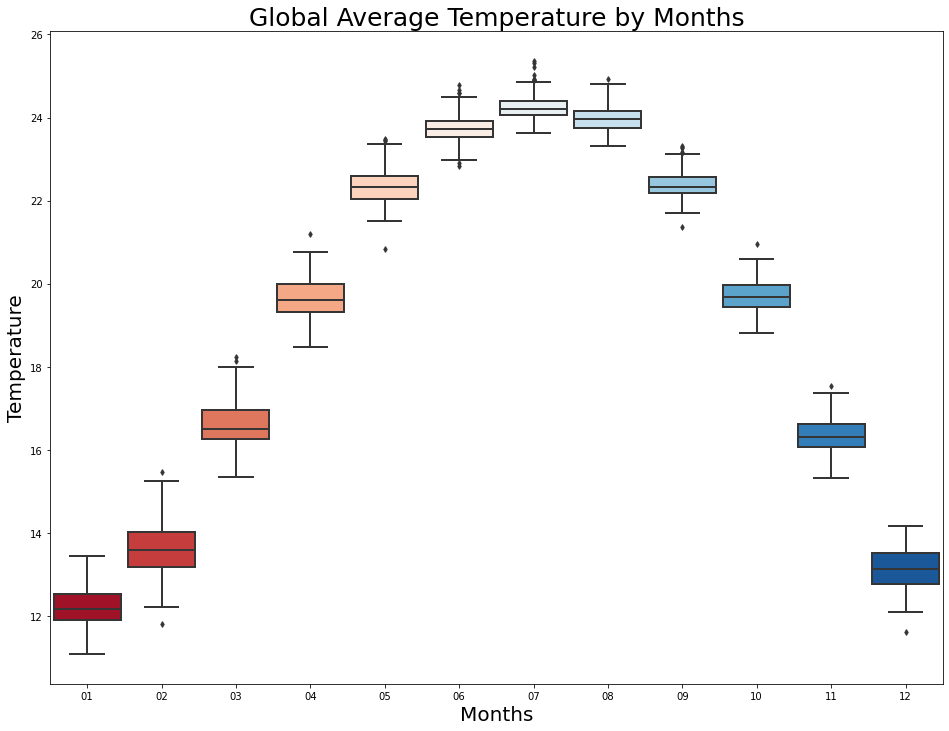

In [9]:
city_temp=MajorCity_Temp.sort_values(by=['month'])
# city_temp = city_temp[city_temp['Country'] == 'China']
year_month = city_temp.groupby(by = ['year','month']).mean().reset_index()
# Figure size
plt.figure(figsize=(16,12))

# The plot
sns.boxplot(x = 'month', y = 'AverageTemperature', data = year_month, palette = "RdBu", saturation = 1, width = 0.9, fliersize=4, linewidth=2)

# Make pretty
plt.title('Global Average Temperature by Months', fontsize = 25)
plt.xlabel('Months', fontsize = 20)
plt.ylabel('Temperature', fontsize = 20)

#### The graph below shows the temperature for some countries for a year, we can see there is seasonality.

In [10]:
# for each country
temp_by_month_df = MajorCity_Temp.groupby(['Country', 'month']).agg({'AverageTemperature': 'mean'}).reset_index()
px.line(temp_by_month_df, x='month', y='AverageTemperature', color='Country')

#### The graph below shows the global temperature for different latitude zone for a year, we can see there is seasonality.

In [11]:
# for latitude zone
temp_by_month_df = temp_avg_by_latitude_df.groupby(['LatitudeZone', 'month']).agg({'AverageTemperature': 'mean'}).reset_index()
px.line(temp_by_month_df, x='month', y='AverageTemperature', color='LatitudeZone')

#### The graph below shows the global temperature for some major cities for  a year, we can see there is seasonality.

In [12]:
# for Peking, Shanghai, Tokyo, Delhi
four_city_df = MajorCity_Temp[(MajorCity_Temp['City'] == 'Shanghai') | (MajorCity_Temp['City'] == 'Peking') | (MajorCity_Temp['City'] == 'Delhi') | (MajorCity_Temp['City'] == 'Tokyo')]
temp_by_month_df = four_city_df.groupby(['month', 'City']).agg({'AverageTemperature': 'mean'}).reset_index()
px.line(temp_by_month_df, x='month', y='AverageTemperature', color='City')

#### The graph below shows the global temperature for land temperature for a year, we can see there is seasonality.

In [13]:
# for LandAverageTemperature, LandMaxTemperature, LandMinTemperature, LandAndOceanAverageTemperature
temp_by_month_df = MajorCity_Temp.groupby('month').agg({'LandAverageTemperature': 'mean', 'LandMaxTemperature': 'mean', 'LandMinTemperature': 'mean', 'LandAndOceanAverageTemperature': 'mean'}).reset_index()
px.line(temp_by_month_df, x='month', y=['LandAverageTemperature', 'LandMaxTemperature', 'LandMinTemperature', 'LandAndOceanAverageTemperature'])

### 3. Stationarity Analysis (Do our data show stationarity)

#### We calculate the p-values to determine if it is stationary.

In [14]:
# Testing of stationary for different data.
from statsmodels.tsa.stattools import adfuller

def stationary_test(val):
    result=adfuller(val)
    print('p-value : '+ str(result[1]) )
    if result[1] <= 0.05:
        print("reject the null hypothesis, data is stationary")
    else:
        print("cannot reject null hypothesis, data is non-stationary ")

#### Global average temperature stationary test

In [15]:
# for global average temperature
stationary_test(temp_avg_df['AverageTemperature'])

p-value : 0.9787594366390332
cannot reject null hypothesis, data is non-stationary 


#### Latitude average temperature stationary test

In [16]:
# for different latitude's average temperature
print('Low latitude:')
stationary_test(temp_avg_by_latitude_df2[temp_avg_by_latitude_df2['LatitudeZone'] == 'low']['AverageTemperature'])
print('')

print('Middle latitude:')
stationary_test(temp_avg_by_latitude_df2[temp_avg_by_latitude_df2['LatitudeZone'] == 'middle']['AverageTemperature'])
print('')

print('High latitude:')
stationary_test(temp_avg_by_latitude_df2[temp_avg_by_latitude_df2['LatitudeZone'] == 'high']['AverageTemperature'])
print('')

Low latitude:
p-value : 0.9768870469549157
cannot reject null hypothesis, data is non-stationary 

Middle latitude:
p-value : 0.9534563067126818
cannot reject null hypothesis, data is non-stationary 

High latitude:
p-value : 4.730095306935411e-13
reject the null hypothesis, data is stationary



#### Major cities' average temperature stationary test

In [17]:
# for Peking, Shanghai, Tokyo and Delhi's average temperature by season
print('Peking Spring: ')
stationary_test(peking_df[peking_df['season'] == 'spring']['AverageTemperature'])
print('')
print('Peking Summer: ')
stationary_test(peking_df[peking_df['season'] == 'summer']['AverageTemperature'])
print('')
print('Peking Fall: ')
stationary_test(peking_df[peking_df['season'] == 'fall']['AverageTemperature'])
print('')
print('Peking Winter: ')
stationary_test(peking_df[peking_df['season'] == 'winter']['AverageTemperature'])
print('')

print('Shanghai Spring: ')
stationary_test(shanghai_df[shanghai_df['season'] == 'spring']['AverageTemperature'])
print('')
print('Shanghai Summer: ')
stationary_test(shanghai_df[shanghai_df['season'] == 'summer']['AverageTemperature'])
print('')
print('Shanghai Fall: ')
stationary_test(shanghai_df[shanghai_df['season'] == 'fall']['AverageTemperature'])
print('')
print('Shanghai Winter: ')
stationary_test(shanghai_df[shanghai_df['season'] == 'winter']['AverageTemperature'])
print('')

print('Tokyo Spring: ')
stationary_test(tokyo_df[tokyo_df['season'] == 'spring']['AverageTemperature'])
print('')
print('Tokyo Summer: ')
stationary_test(tokyo_df[tokyo_df['season'] == 'summer']['AverageTemperature'])
print('')
print('Tokyo Fall: ')
stationary_test(tokyo_df[tokyo_df['season'] == 'fall']['AverageTemperature'])
print('')
print('Tokyo Winter: ')
stationary_test(tokyo_df[tokyo_df['season'] == 'winter']['AverageTemperature'])
print('')

print('Delhi Spring: ')
stationary_test(delhi_df[delhi_df['season'] == 'spring']['AverageTemperature'])
print('')
print('Delhi Summer: ')
stationary_test(delhi_df[delhi_df['season'] == 'summer']['AverageTemperature'])
print('')
print('Delhi Fall: ')
stationary_test(delhi_df[delhi_df['season'] == 'fall']['AverageTemperature'])
print('')
print('Delhi Winter: ')
stationary_test(delhi_df[delhi_df['season'] == 'winter']['AverageTemperature'])
print('')

Peking Spring: 
p-value : 0.36241570758725494
cannot reject null hypothesis, data is non-stationary 

Peking Summer: 
p-value : 0.08295275393885598
cannot reject null hypothesis, data is non-stationary 

Peking Fall: 
p-value : 0.19095828406525844
cannot reject null hypothesis, data is non-stationary 

Peking Winter: 
p-value : 0.30296847702201357
cannot reject null hypothesis, data is non-stationary 

Shanghai Spring: 
p-value : 0.3405358341336202
cannot reject null hypothesis, data is non-stationary 

Shanghai Summer: 
p-value : 0.08580008514824622
cannot reject null hypothesis, data is non-stationary 

Shanghai Fall: 
p-value : 0.17152958337741264
cannot reject null hypothesis, data is non-stationary 

Shanghai Winter: 
p-value : 0.07281625408193863
cannot reject null hypothesis, data is non-stationary 

Tokyo Spring: 
p-value : 0.17273534455855
cannot reject null hypothesis, data is non-stationary 

Tokyo Summer: 
p-value : 0.08358822480107625
cannot reject null hypothesis, data is

#### Land average temperature stationary test

In [18]:
# for globally land average temperature, land max temperature, land min temperature, land & ocean average temperature
print('LandAverageTemperature: ')
stationary_test(all_temp_df['LandAverageTemperature'])
print('')

print('LandMaxTemperature: ')
stationary_test(all_temp_df['LandMaxTemperature'])
print('')

print('LandMinTemperature: ')
stationary_test(all_temp_df['LandMinTemperature'])
print('')

print('LandAndOceanAverageTemperature: ')
stationary_test(all_temp_df['LandAndOceanAverageTemperature'])
print('')

LandAverageTemperature: 
p-value : 0.9839098592415725
cannot reject null hypothesis, data is non-stationary 

LandMaxTemperature: 
p-value : 0.9892471609238631
cannot reject null hypothesis, data is non-stationary 

LandMinTemperature: 
p-value : 0.9739327431920419
cannot reject null hypothesis, data is non-stationary 

LandAndOceanAverageTemperature: 
p-value : 0.9529226247187341
cannot reject null hypothesis, data is non-stationary 



## For Regression And Boosting 
Member in charge：  
*   Yinuo Zhao

### 1. Analysis of multicollinerity

In [19]:
# load the coresponding dataset 
data = pd.read_csv('./processedData/processed_data_120.csv')
# since we want to explore if there is any multicolinearity between x variables
data.drop(columns=['target_AvgTemp'], inplace=True)
data

datetime  AverageTemperature  AverageTemperatureUncertainty  \
0       1903-01-31              26.098                          1.379   
1       1903-02-28              26.682                          1.252   
2       1903-03-31              28.107                          0.870   
3       1903-04-30              27.139                          1.221   
4       1903-05-31              26.066                          1.028   
...            ...                 ...                            ...   
119995  2002-08-31              23.497                          0.245   
119996  2002-09-30              18.337                          0.154   
119997  2002-10-31              12.804                          0.450   
119998  2002-11-30               6.092                          0.437   
119999  2002-12-31              -1.590                          0.178   

           City        Country  Latitude  Longitude  LandAverageTemperature  \
0       Abidjan  Côte D'Ivoire      5.63      -3.23                   2.514   
1       Abidjan  Côte D'Ivoire      5.63      -3.23                   3.555   
2       Abidjan  Côte D'Ivoire      5.63      -3.23                   4.930   
3       Abidjan  Côte D'Ivoire      5.63      -3.23                   7.832   
4       Abidjan  Côte D'Ivoire      5.63      -3.23                  10.794   
...         ...            ...       ...        ...                     ...   
119995     Xian          China     34.56     108.97                  14.560   
119996     Xian          China     34.56     108.97                  12.950   
119997     Xian          China     34.56     108.97                   9.988   
119998     Xian          China     34.56     108.97                   6.892   
119999     Xian          China     34.56     108.97                   4.038   

        LandAverageTemperatureUncertainty  LandMaxTemperature  ...  \
0                                   0.224               8.415  ...   
1                                   0.247               9.297  ...   
2                                   0.212              10.963  ...   
3                                   0.292              13.958  ...   
4                                   0.305              16.672  ...   
...                                   ...                 ...  ...   
119995                              0.067              20.444  ...   
119996                              0.103              18.785  ...   
119997                              0.079              15.599  ...   
119998                              0.120              12.480  ...   
119999                              0.064               9.357  ...   

        Roll_12_Avg  Roll_24_Avg  Roll_36_Avg  Roll_min_Temp  Roll_max_Temp  \
0         25.551250    25.761458    25.886556         23.464         28.395   
1         25.493917    25.710167    25.855056         23.464         28.395   
2         25.517667    25.734958    25.847056         23.464         28.395   
3         25.560500    25.748417    25.831306         23.464         28.395   
4         25.521583    25.757958    25.812222         23.464         28.395   
...             ...          ...          ...            ...            ...   
119995    12.708667    12.567917    12.545167         -6.418         26.762   
119996    12.786750    12.589333    12.500028         -6.418         26.762   
119997    12.798833    12.659667    12.523778         -6.418         26.762   
119998    12.807583    12.742875    12.527028         -6.418         26.762   
119999    12.816000    12.623917    12.476611         -6.418         26.762   

        Roll_avg_Temp  Lag_1_LandAvgTemp  Lag_1_LandMaxTemp  \
0           25.881405              2.713             -2.992   
1           25.902474              2.514             -3.187   
2           25.959000              3.555             -2.490   
3           25.988500              4.930             -1.158   
4           25.990390              7.832              1.698   
...             

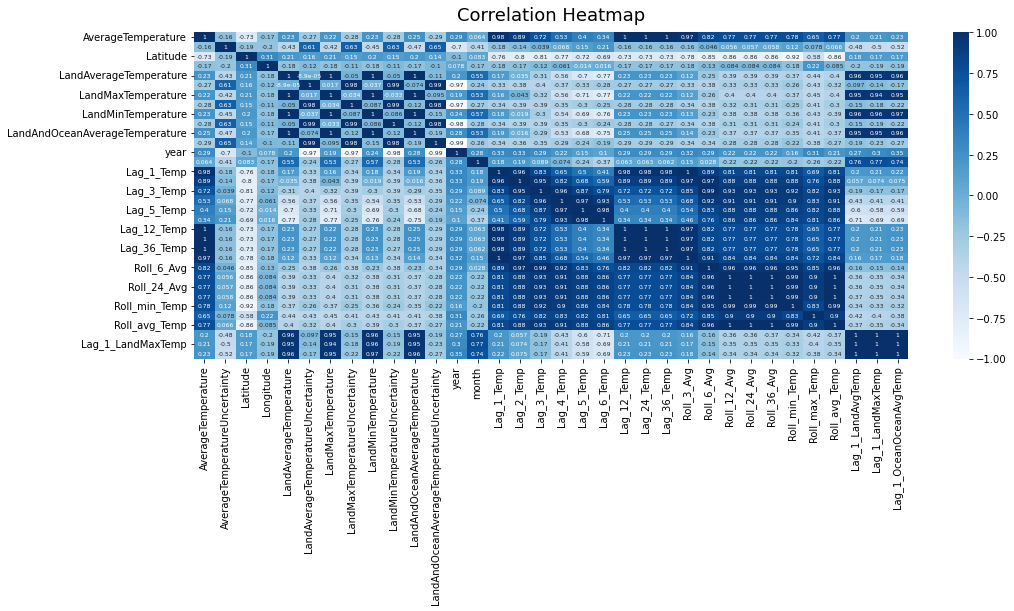

In [20]:
corr = data.corr()
# visualize the correlation via heatmap 
plt.figure(figsize=(16, 6))
heatmap1 = sns.heatmap(corr.corr(), vmin=-1, vmax=1, annot=True, annot_kws={"size": 6},cmap='Blues')
heatmap1.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12)
plt.show()

### 2. Analysis of correlation 

In [21]:
# find Features Correlation with Y variable 
corrs = []
for i in range(120, 133):
    data = pd.read_csv(f'./processedData/processed_data_{i}.csv')
    corr = data.corr()[['target_AvgTemp']]
    corr['m'] = i
    corrs.append(corr)
corrs = pd.concat(corrs)
corrs = corrs.reset_index()
corrs.rename(columns={'index':'x_name'}, inplace=True)
corrs

x_name  target_AvgTemp    m
0               AverageTemperature        0.987353  120
1    AverageTemperatureUncertainty        0.025168  120
2                         Latitude       -0.350593  120
3                        Longitude        0.033418  120
4           LandAverageTemperature        0.439359  120
..                             ...             ...  ...
450                  Roll_avg_Temp        0.750466  132
451              Lag_1_LandAvgTemp        0.360638  132
452              Lag_1_LandMaxTemp        0.351653  132
453        Lag_1_OceanOceanAvgTemp        0.372050  132
454                 target_AvgTemp        1.000000  132

[455 rows x 3 columns]

<AxesSubplot:xlabel='x_name', ylabel='target_AvgTemp'>

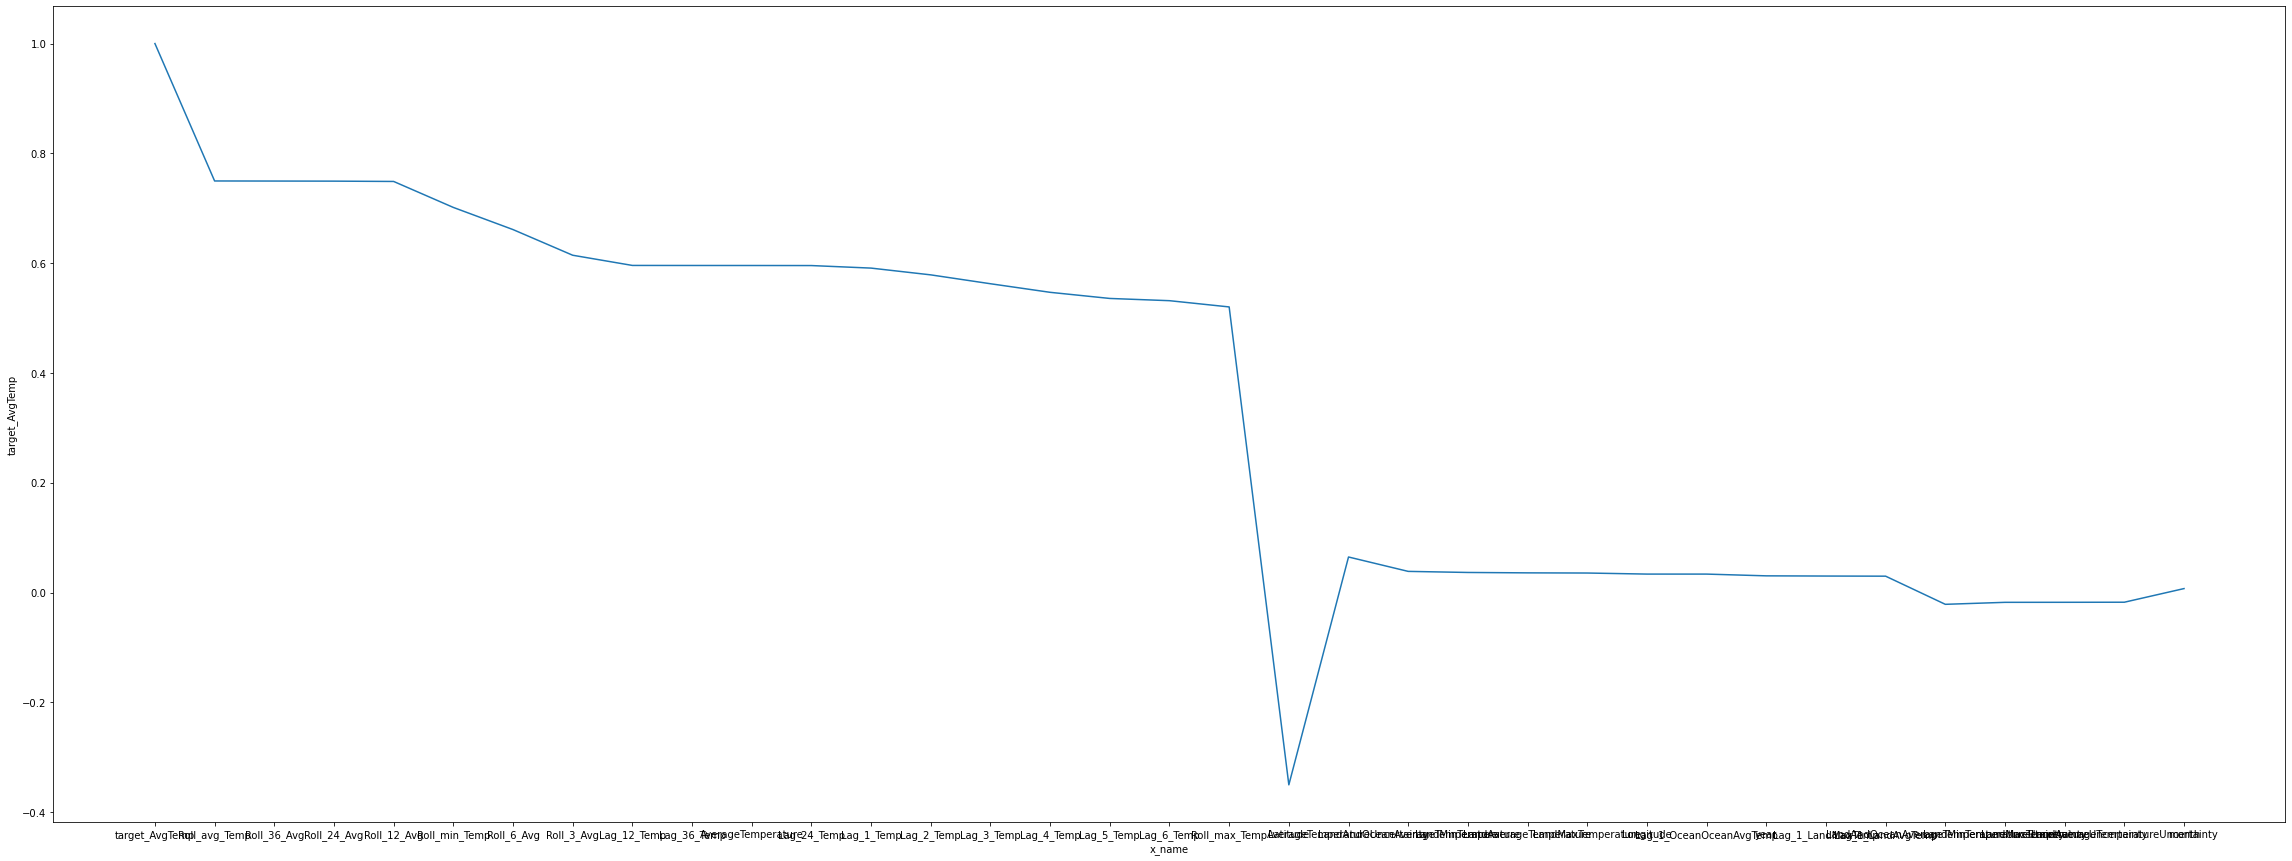

In [22]:
plt.figure(figsize=(40, 15))
avg_corrs = corrs.groupby(['x_name']).agg({'target_AvgTemp':'mean'}).reset_index()
avg_corrs['abs'] = np.abs(avg_corrs['target_AvgTemp'])
avg_corrs = avg_corrs.sort_values(by=['abs'], ascending=False)
sns.lineplot(data=avg_corrs, x='x_name', y='target_AvgTemp')

In [23]:
avg_corrs

x_name  target_AvgTemp       abs
33                             target_AvgTemp        1.000000  1.000000
29                              Roll_avg_Temp        0.749684  0.749684
26                                Roll_36_Avg        0.749538  0.749538
25                                Roll_24_Avg        0.749373  0.749373
24                                Roll_12_Avg        0.748798  0.748798
31                              Roll_min_Temp        0.701484  0.701484
28                                 Roll_6_Avg        0.661143  0.661143
27                                 Roll_3_Avg        0.614394  0.614394
2                                 Lag_12_Temp        0.595823  0.595823
9                                 Lag_36_Temp        0.595737  0.595737
0                          AverageTemperature        0.595694  0.595694
7                                 Lag_24_Temp        0.595591  0.595591
6                                  Lag_1_Temp        0.590956  0.590956
8                                  Lag_2_Temp        0.578630  0.578630
10                                 Lag_3_Temp        0.562467  0.562467
11                                 Lag_4_Temp        0.546844  0.546844
12                                 Lag_5_Temp        0.535680  0.535680
13                                 Lag_6_Temp        0.531600  0.531600
30                              Roll_max_Temp        0.520223  0.520223
22                                   Latitude       -0.350334  0.350334
1               AverageTemperatureUncertainty        0.064700  0.064700
14             LandAndOceanAverageTemperature        0.038492  0.038492
20                         LandMinTemperature        0.036517  0.036517
16                     LandAverageTemperature        0.035801  0.035801
18                         LandMaxTemperature        0.035497  0.035497
23                                  Longitude        0.033570  0.033570
5                     Lag_1_OceanOceanAvgTemp        0.033545  0.033545
34                                       year        0.030363  0.030363
4                           Lag_1_LandMaxTemp        0.029996  0.029996
3                           Lag_1_LandAvgTemp        0.029758  0.029758
15  LandAndOceanAverageTemperatureUncertainty       -0.021513  0.021513
21              LandMinTemperatureUncertainty       -0.017888  0.017888
19              LandMaxTemperatureUncertainty       -0.017822  0.017822
17          LandAverageTemperatureUncertainty       -0.017678  0.017678
32                                      month        0.007165  0.007165

<AxesSubplot:xlabel='x_name', ylabel='target_AvgTemp'>

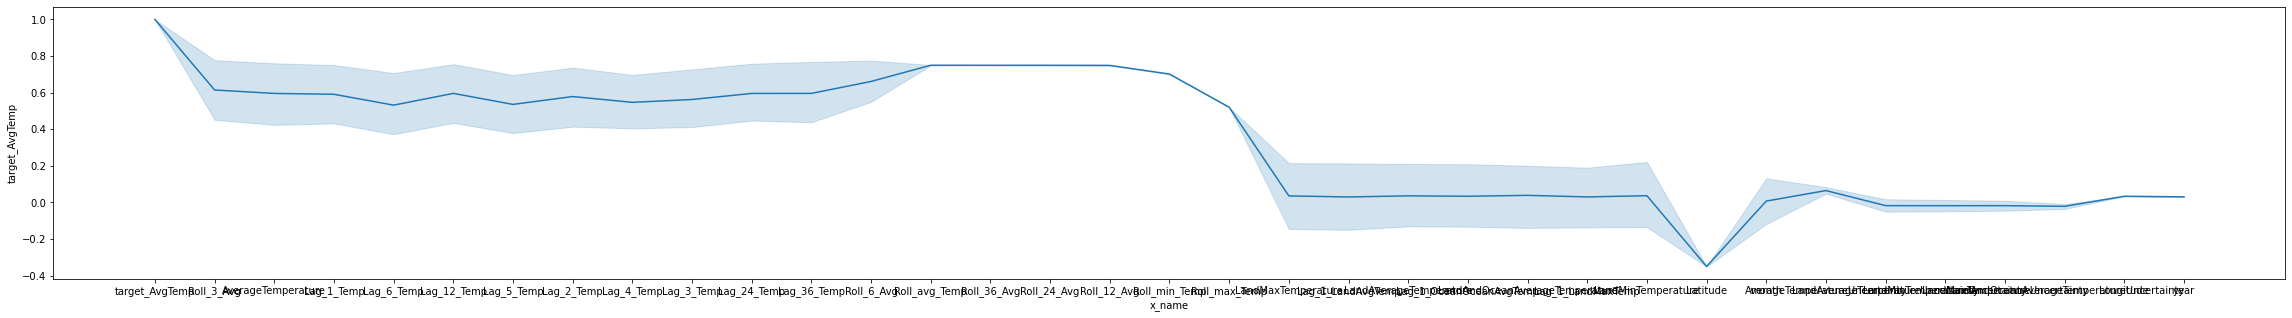

In [24]:
plt.figure(figsize=(40, 5))
corrs['abs'] = np.abs(corrs['target_AvgTemp'])
corrs = corrs.sort_values(by=['abs'], ascending=False)
sns.lineplot(data=corrs, x='x_name', y='target_AvgTemp')

In [25]:
# update the datasets according to EDA
for i in range(120,133):
    data = pd.read_csv(f'./processedData/processed_data_{i}.csv')
    data.drop(columns=['AverageTemperatureUncertainty','LandAndOceanAverageTemperature','LandMinTemperature','LandAverageTemperature','LandMaxTemperature','Longitude','Lag_1_OceanOceanAvgTemp','year','Lag_1_LandMaxTemp','Lag_1_LandAvgTemp','LandAndOceanAverageTemperatureUncertainty','LandMinTemperatureUncertainty','LandMaxTemperatureUncertainty','LandAverageTemperatureUncertainty','month'],inplace = True)
    data.to_csv(f'./edaData/processed_data_{i}.csv', index=False)

### 3. One Hot Encoding & PCA

In [26]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA

In [27]:
# use only 120month dataset to perform One Hot Encoder and PCA (just to see if it's works)
data = pd.read_csv(f'./edaData/processed_data_120.csv')
#OneHotEncoder for city 
city_encoder = OneHotEncoder()
city_encoder.fit(data[['City']])
city = city_encoder.transform(data[['City']]).toarray()
city = pd.DataFrame(city, columns= [str(x) for x in  city_encoder.categories_[0].tolist()])
#OneHotEncoder for country
country_encoder = OneHotEncoder()
country_encoder.fit(data[['Country']])
country = country_encoder.transform(data[['Country']]).toarray()
country = pd.DataFrame(country, columns= [str(x) for x in  country_encoder.categories_[0].tolist()])
# create new df
data:pd.DataFrame = pd.concat([data, city,country], axis = 1)
data_temp = data[['datetime', 'target_dates', 'target_AvgTemp']].copy(deep=True)
data.drop(columns=['datetime', 'target_dates', 'target_AvgTemp', 'City','Country'], inplace=True)
data

AverageTemperature  Latitude  Lag_1_Temp  Lag_2_Temp  Lag_3_Temp  \
0                   26.098      5.63      25.145      25.889      24.590   
1                   26.682      5.63      26.098      25.145      25.889   
2                   28.107      5.63      26.682      26.098      25.145   
3                   27.139      5.63      28.107      26.682      26.098   
4                   26.066      5.63      27.139      28.107      26.682   
...                    ...       ...         ...         ...         ...   
119995              23.497     34.56      25.513      24.147      17.176   
119996              18.337     34.56      23.497      25.513      24.147   
119997              12.804     34.56      18.337      23.497      25.513   
119998               6.092     34.56      12.804      18.337      23.497   
119999              -1.590     34.56       6.092      12.804      18.337   

        Lag_4_Temp  Lag_5_Temp  Lag_6_Temp  Lag_12_Temp  Lag_24_Temp  ...  \
0           24.307      23.464      23.586       26.556       25.915  ...   
1           24.590      24.307      23.464       27.370       27.913  ...   
2           25.889      24.590      24.307       27.822       27.512  ...   
3           25.145      25.889      24.590       26.625       26.816  ...   
4           26.098      25.145      25.889       26.533       25.837  ...   
...            ...         ...         ...          ...          ...  ...   
119995      13.001       9.357       4.302       23.148       22.517  ...   
119996      17.176      13.001       9.357       17.400       17.823  ...   
119997      24.147      17.176      13.001       12.659       11.116  ...   
119998      25.513      24.147      17.176        5.987        4.095  ...   
119999      23.497      25.513      24.147       -1.691        1.265  ...   

        Syria  Taiwan  Tanzania  Thailand  Turkey  Ukraine  United Kingdom  \
0         0.0     0.0       0.0       0.0     0.0      0.0             0.0   
1         0.0     0.0       0.0       0.0     0.0      0.0             0.0   
2         0.0     0.0       0.0       0.0     0.0      0.0             0.0   
3         0.0     0.0       0.0       0.0     0.0      0.0             0.0   
4         0.0     0.0       0.0       0.0     0.0      0.0             0.0   
...       ...     ...       ...       ...     ...      ...             ...   
119995    0.0     0.0       0.0       0.0     0.0      0.0             0.0   
119996    0.0     0.0       0.0       0.0     0.0      0.0             0.0   
119997    0.0     0.0       0.0       0.0     0.0      0.0             0.0   
119998    0.0     0.0       0.0       0.0     0.0      0.0             0.0   
119999    0.0     0.0       0.0       0.0     0.0      0.0             0.0   

        United States  Vietnam  Zimbabwe  
0                 0.0      0.0       0.0  
1                 0.0      0.0       0.0  
2                 0.0      0.0       0.0  
3                 0.0      0.0       0.0  
4                 0.0      0.0       0.0  
...               ...      ...       ...  
119995            0.0      0.0       0.0  
119996            0.0      0.0       0.0  
119997            0.0      0.0       0.0  
119998            0.0      0.0       0.0  
119999            0.0      0.0       0.0  

[120000 rows x 168 columns]

In [28]:
data.shape

(120000, 168)

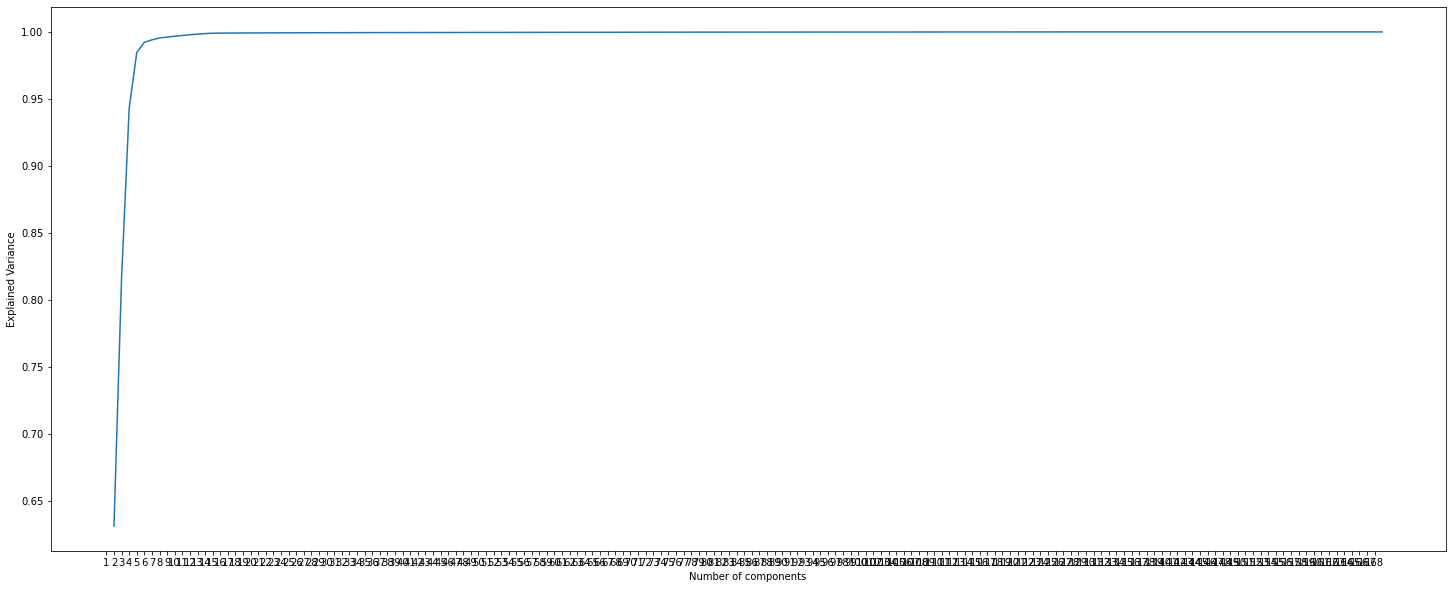

In [29]:
# PCA process
n = data.shape[1]
pca = PCA(n)
pca_data = pca.fit_transform(data)
eigenvalues = pca.explained_variance_ratio_
cum_evr = np.cumsum(eigenvalues)
plt.figure(figsize=(25, 10))
plt.plot(np.arange(1, n+1), eigenvalues[:n].cumsum())
plt.xticks(np.arange(len(cum_evr)), np.arange(1, len(cum_evr)+1))
plt.xlabel("Number of components")
plt.ylabel("Explained Variance")
plt.show()

In [30]:
# n=5 is best
n = 5
pca = PCA(n)
pca_data = pca.fit_transform(data)
pca_data = pd.DataFrame(pca_data, columns=['x1', 'x2', 'x3','x4','x5'])
pca_data = pd.concat([pca_data, data_temp], axis=1)
pca_data

x1         x2         x3         x4        x5    datetime  \
0      -32.834082   1.778809   0.975421  -3.283206  3.683642  1903-01-31   
1      -34.741049   0.476480   1.845087  -3.186510  3.341035  1903-02-28   
2      -36.223572  -0.314032   1.693953  -2.885233  3.061330  1903-03-31   
3      -36.430087  -0.155845   0.375297  -1.700737  3.189711  1903-04-30   
4      -36.195634   0.385661  -1.307018  -0.856033  3.336273  1903-05-31   
...           ...        ...        ...        ...       ...         ...   
119995  13.921734 -18.914947  19.571972  12.401105 -3.029281  2002-08-31   
119996  14.694922 -15.307129   7.042679  17.575093 -2.581903  2002-09-30   
119997  19.840714  -8.570626  -6.970759  19.562063 -2.124491  2002-10-31   
119998  28.172136   0.159696 -20.169897  16.503562 -2.157922  2002-11-30   
119999  39.041562   9.626550 -29.629836   8.870898 -2.359842  2002-12-31   

       target_dates  target_AvgTemp  
0        1913-01-31          27.551  
1        1913-02-28          27.949  
2        1913-03-31          27.822  
3        1913-04-30          27.501  
4        1913-05-31          25.832  
...             ...             ...  
119995   2012-08-31          23.885  
119996   2012-09-30          17.028  
119997   2012-10-31          12.399  
119998   2012-11-30           4.736  
119999   2012-12-31          -0.822  

[120000 rows x 8 columns]

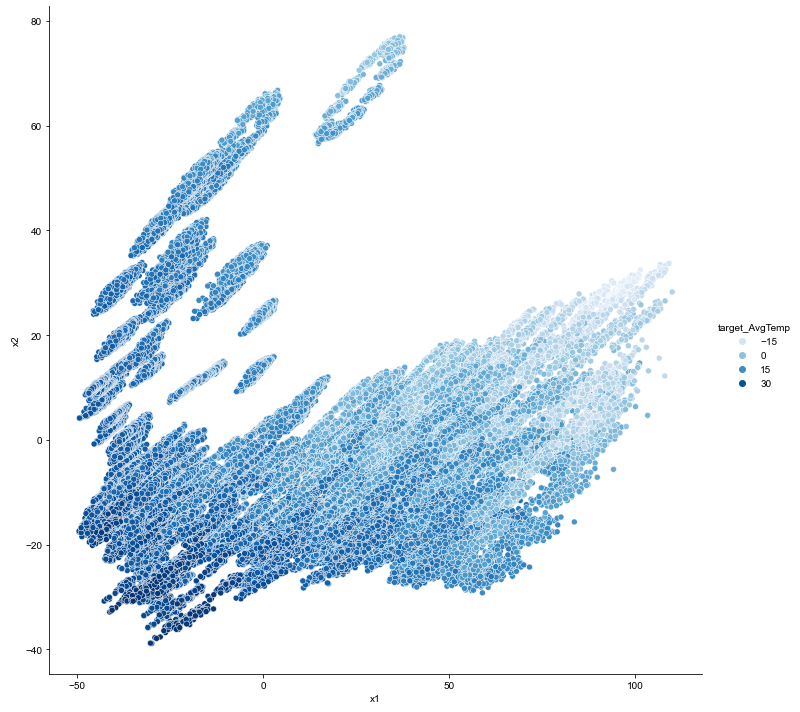

In [31]:
g=sns.relplot(x='x1',y='x2',data=pca_data,
            palette='Blues',
            height=10,
            hue='target_AvgTemp',
            sizes=(50, 200),
           )

sns.set(style='darkgrid', font='sans-serif', font_scale=4,)

In [32]:
# Apply OneHotEncoder + PCA on all datasets and save them into pcaData folder
for j in range(120, 133):
    data = pd.read_csv(f'./edaData/processed_data_{j}.csv')
    #OneHotEncoder for city 
    city_encoder = OneHotEncoder()
    city_encoder.fit(data[['City']])
    city = city_encoder.transform(data[['City']]).toarray()
    city = pd.DataFrame(city, columns= [str(x) for x in  city_encoder.categories_[0].tolist()])
    #OneHotEncoder for country
    country_encoder = OneHotEncoder()
    country_encoder.fit(data[['Country']])
    country = country_encoder.transform(data[['Country']]).toarray()
    country = pd.DataFrame(country, columns= [str(x) for x in  country_encoder.categories_[0].tolist()])
    # create new df
    data:pd.DataFrame = pd.concat([data, city,country], axis = 1)
    data_temp = data[['datetime', 'target_dates', 'target_AvgTemp']].copy(deep=True)
    data.drop(columns=['datetime', 'target_dates', 'target_AvgTemp', 'City','Country'], inplace=True)
    n = 5
    pca = PCA(n)
    pca_data = pca.fit_transform(data)
    pca_data = pd.DataFrame(pca_data, columns=['x1', 'x2', 'x3','x4','x5'])
    pca_data = pd.concat([pca_data, data_temp], axis=1)
    pca_data.to_csv(f'./pcaData/pca_data_{j}.csv', index=False)

In [33]:
# kernel PCA with default hyperparameter values

## Arima for Temperature Difference

#### We use arima for temperature difference forcasting. First we need to find the correlation first

In [34]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

LA_Temp = MajorCity_Temp[MajorCity_Temp['City'] == 'Los Angeles']
LA_Temp = LA_Temp.sort_values(by=['year', 'month'])
LA_Temp['temp_diff']=LA_Temp['AverageTemperature']-LA_Temp['AverageTemperature'].shift(12)
LA_Temp.set_index('datetime',inplace=True)

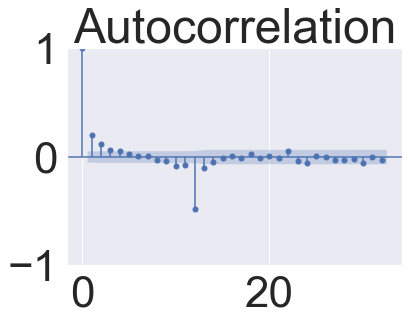

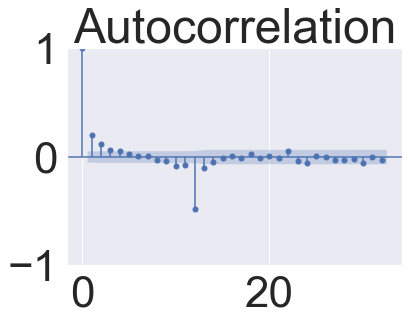

In [35]:

plot_acf(LA_Temp['temp_diff'].dropna())

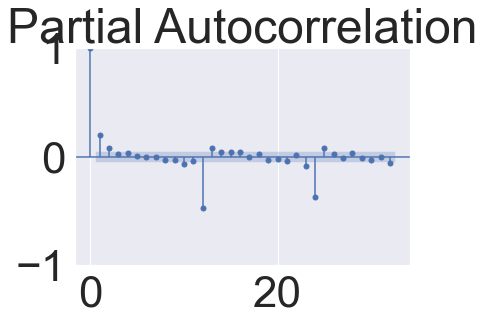

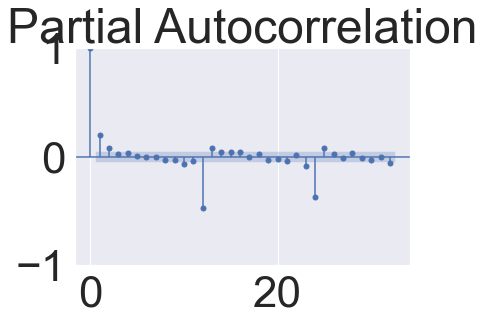

In [36]:
plot_pacf(LA_Temp['temp_diff'].dropna())

#### We then use arima as our model to predict future temperature 

D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

D:\Anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



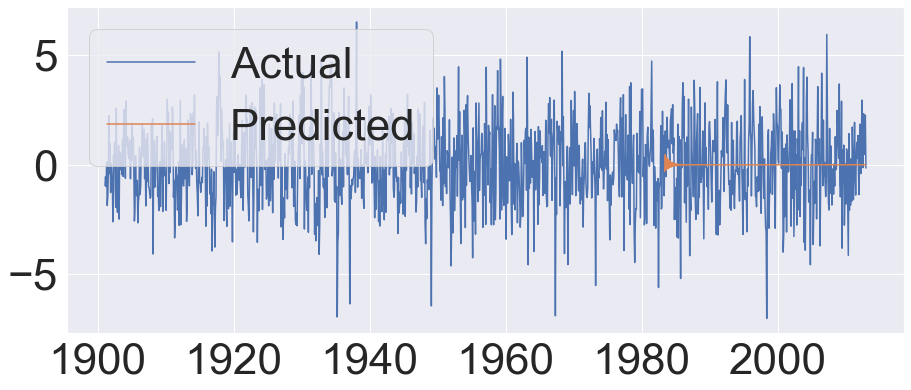

In [37]:
training_data=LA_Temp[0:1000]
test_data = LA_Temp[1000:]

arima = ARIMA(training_data['temp_diff'], order=(2,1,3))
model = arima.fit()
#predictions 
predictions=model.predict(start=test_data['temp_diff'].index[0], end=test_data['temp_diff'].index[-1], typ='levels')

fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(LA_Temp.index, LA_Temp['temp_diff'], label='Actual')
ax.plot(predictions.index, predictions, label='Predicted')
ax.legend(loc='upper left')
plt.show()

#### We calculate the errors

In [38]:
np.sqrt(mean_squared_error(test_data['temp_diff'],predictions))

1.9396016991260563

#### Prediction error is low

## Arima for Average Temperature

#### We then use arima to predict future average temperature for Los Angeles. Using one city can give us enough data to predict. We first check the correlations.

In [39]:
LA_Temp = MajorCity_Temp[MajorCity_Temp['City'] == 'Los Angeles']
LA_Temp = LA_Temp.sort_values(by=['year', 'month'])
LA_Temp['temp_diff']=LA_Temp['AverageTemperature']-LA_Temp['AverageTemperature'].shift(12)
LA_Temp.set_index('datetime',inplace=True)
# LA_Temp=LA_Temp[['temp_diff']]
LA_Temp

AverageTemperature  AverageTemperatureUncertainty         City  \
datetime                                                                     
1900-01-31              10.292                          0.516  Los Angeles   
1900-02-28              11.318                          0.360  Los Angeles   
1900-03-31              13.929                          0.917  Los Angeles   
1900-04-30              12.600                          0.804  Los Angeles   
1900-05-31              17.529                          0.415  Los Angeles   
...                        ...                            ...          ...   
2012-08-31              26.892                          0.315  Los Angeles   
2012-09-30              24.745                          0.354  Los Angeles   
2012-10-31              18.712                          0.283  Los Angeles   
2012-11-30              13.903                          0.266  Los Angeles   
2012-12-31               8.712                          0.438  Los Angeles   

                  Country  Latitude  Longitude  LandAverageTemperature  \
datetime                                                                 
1900-01-31  United States     34.56     -118.7                   1.461   
1900-02-28  United States     34.56     -118.7                   3.098   
1900-03-31  United States     34.56     -118.7                   5.492   
1900-04-30  United States     34.56     -118.7                   8.223   
1900-05-31  United States     34.56     -118.7                  11.385   
...                   ...       ...        ...                     ...   
2012-08-31  United States     34.56     -118.7                  14.720   
2012-09-30  United States     34.56     -118.7                  13.040   
2012-10-31  United States     34.56     -118.7                  10.428   
2012-11-30  United States     34.56     -118.7                   7.156   
2012-12-31  United States     34.56     -118.7                   4.102   

            LandAverageTemperatureUncertainty  LandMaxTemperature  \
datetime                                                            
1900-01-31                              0.276               7.193   
1900-02-28                              0.416               9.181   
1900-03-31                              0.261              11.377   
1900-04-30                              0.292              13.972   
1900-05-31                              0.357              17.415   
...                                       ...                 ...   
2012-08-31                              0.069              20.709   
2012-09-30                              0.069              19.074   
2012-10-31                              0.098              16.203   
2012-11-30                              0.116              12.689   
2012-12-31                              0.090               9.498   

            LandMaxTemperatureUncertainty  LandMinTemperature  \
datetime                                                        
1900-01-31                          0.465              -4.102   
1900-02-28                          0.604              -2.814   
1900-03-31                          0.327              -0.680   
1900-04-30                          0.342               2.131   
1900-05-31                          0.329               5.179   
...                                   ...                 ...   
2012-08-31                          0.079               8.840   
2012-09-30                          0.093               7.176   
2012-10-31                          0.099               4.765   
2012-11-30                          0.150               1.796   
2012-12-31                          0.149              -1.162   

            LandMinTemperatureUncertainty  LandAndOceanAverageTemperature  \
datetime                                                                    
1900-01-31                          0.395                          13.142   
1900-02-28                          0.626                  

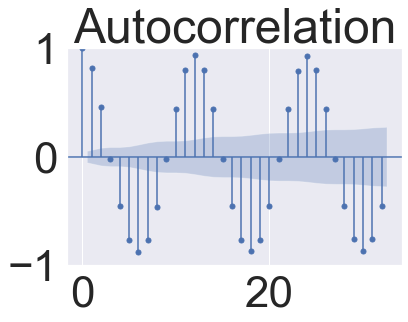

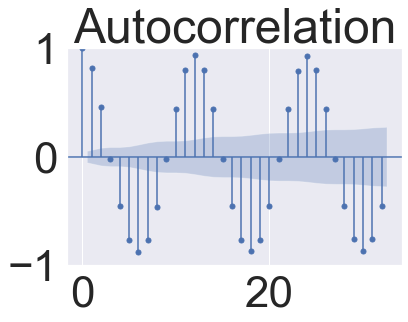

In [40]:
plot_acf(LA_Temp['AverageTemperature'].dropna())

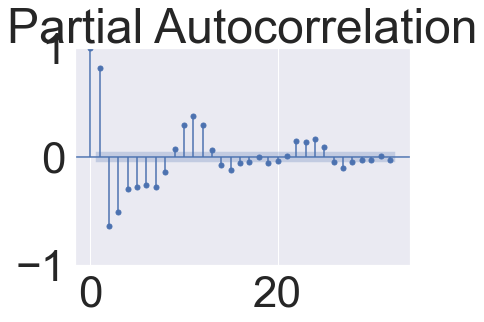

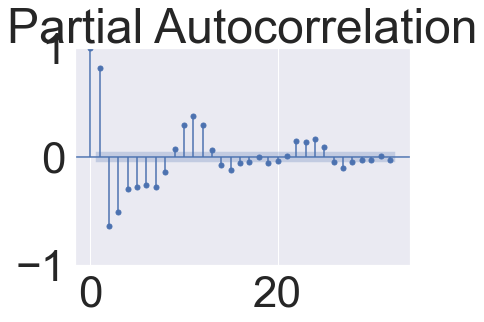

In [41]:
plot_pacf(LA_Temp['AverageTemperature'].dropna())

#### We then predict future average temperatures using arima.

D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.



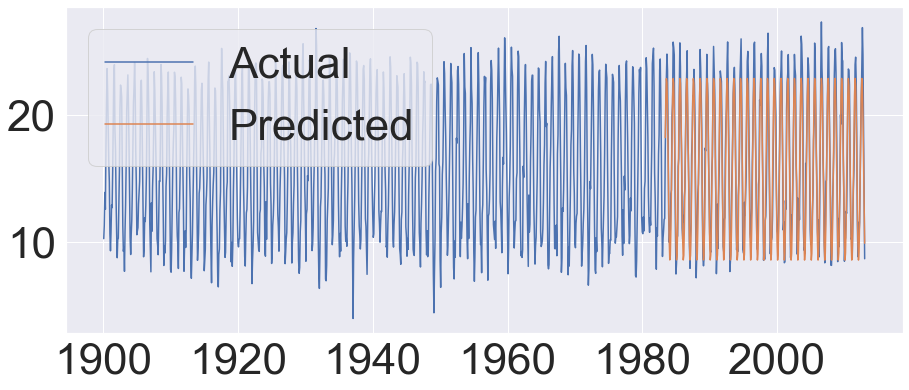

In [42]:
training_data=LA_Temp[0:1000]
test_data = LA_Temp[1000:]

arima = ARIMA(training_data['AverageTemperature'], order=(2,1,3))
model = arima.fit()
#predictions 
predictions=model.predict(start=test_data['AverageTemperature'].index[0], end=test_data['AverageTemperature'].index[-1], typ='levels')

fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(LA_Temp.index, LA_Temp['AverageTemperature'], label='Actual')
ax.plot(predictions.index, predictions, label='Predicted')
ax.legend(loc='upper left')
plt.show()

In [43]:
np.sqrt(mean_squared_error(test_data['AverageTemperature'],predictions))

1.8488736715275085

#### Prediction error is low

## Challenges

Because we are trying to predict our datas, we are not sure if the model we choose is appropriate. Choosing the right model for a given problem is a critical part of the modeling process. Model selection involves balancing the tradeoff between model complexity and performance, and there are a wide range of modeling techniques to choose from, each with its own strengths and weaknesses. We then choose the ones that are introduce in class. However, we have not learn these models in depth. The way we are using it may be incorrect. Also there could be more different ways to show our data by using differnt plot to make it more lively.

## Potential Next Steps

There are several things we can do next:
1. Refine the model: Depending on the performance of the initial model, the error can be lower. We could be more sophisticated about the way we use Arima.

2. Refine our plot: The plot we have are straight-forward. We can have more ways in different aspects to show out data.

3. Trying to use different models: We only have chosen two models. We can try to use some other models on our data to generete more interesting results.